In [1]:
%pip install datasets trl peft dagshub mlflow torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.4/517.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.3/261.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.2/764.

In [2]:
import random
from datasets import Dataset
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from peft import LoraConfig, AutoPeftModelForCausalLM
from trl import SFTTrainer, SFTConfig
import os

In [3]:
os.sep = "/"

In [4]:
# MODEL_ID = "roneneldan/TinyStories-33M"
MODEL_ID = "distilgpt2"
# MODEL_ID = "sshleifer/tiny-gpt2"

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
def check_result(model):
    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device="cpu",
    )

    prompts = [
        "2 + 3 =",
        "7 + 1 =",
        "9 + 0 =",
        "2 + 2 =",
        "1 + 1 =",
        "9 + 9 =",
        "2 + 9 =",
        "0 + 0 =",
    ]

    for p in prompts:
        out = gen(p, max_new_tokens=3, do_sample=False)[0]["generated_text"]
        print(f"PROMPT: {p!r}  →  {out!r}")


In [7]:
model_original = AutoModelForCausalLM.from_pretrained(MODEL_ID)
model_original.to("cpu")
model_original.eval()

check_result(model_original)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cpu
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


PROMPT: '2 + 3 ='  →  '2 + 3 = 0.5'
PROMPT: '7 + 1 ='  →  '7 + 1 = 0.0'
PROMPT: '9 + 0 ='  →  '9 + 0 = 0.0'
PROMPT: '2 + 2 ='  →  '2 + 2 = 0.0'
PROMPT: '1 + 1 ='  →  '1 + 1 = 0.0'
PROMPT: '9 + 9 ='  →  '9 + 9 = 0.5'
PROMPT: '2 + 9 ='  →  '2 + 9 = 0.5'
PROMPT: '0 + 0 ='  →  '0 + 0 = 0.0'


In [8]:
def build_sft_dataset(n_samples: int = 200) -> Dataset:
    """
    Генерируем простые примеры вида: "a + b = c"
    """
    data = []
    for _ in range(n_samples):
        a = random.randint(0, 9)
        b = random.randint(0, 9)
        prompt = f"{a} + {b} ="
        answer = a + b
        text = f"{prompt} {answer}"
        data.append({"text": text})
    return Dataset.from_list(data)

random.seed(42)
dataset = build_sft_dataset(1000)
dataset[0:10]

{'text': ['1 + 0 = 1',
  '4 + 3 = 7',
  '3 + 2 = 5',
  '1 + 8 = 9',
  '1 + 9 = 10',
  '6 + 0 = 6',
  '0 + 1 = 1',
  '3 + 3 = 6',
  '8 + 9 = 17',
  '0 + 8 = 8']}

# Сравнение старой и новой функций задания сумм

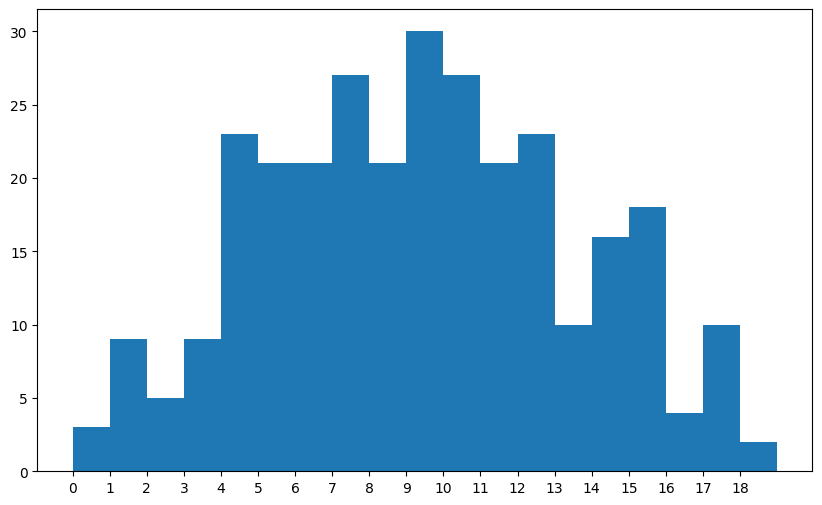

In [9]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset # Используем datasets, как в вашем исходном коде

def build_sft_dataset_with_sums(n_samples: int = 200) -> Dataset:
    """
    Генерируем простые примеры вида: "a + b = c" и сохраняем само значение суммы.
    """
    data = []
    for _ in range(n_samples):
        a = random.randint(0, 9)
        b = random.randint(0, 9)

        prompt = f"{a} + {b} ="
        answer = a + b
        text = f"{prompt} {answer}"

        data.append({
            "text": text,
            "answer": answer
        })
    return Dataset.from_list(data)

random.seed(42)
dataset = build_sft_dataset_with_sums(300)

df = dataset.to_pandas()
sums_list = df['answer'].tolist()
max_sum = 18

plt.figure(figsize=(10, 6))
plt.hist(sums_list, bins=range(max_sum + 2))
plt.xticks(range(max_sum + 1))
plt.show()

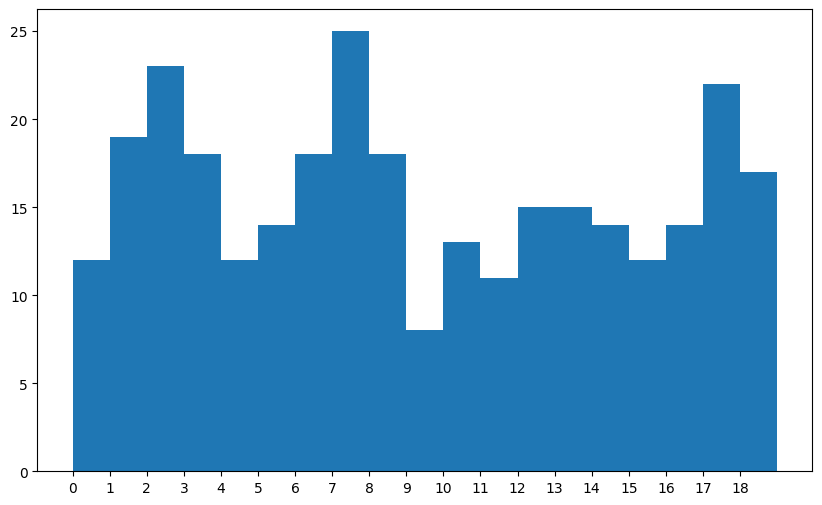

In [10]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset

def find_random_pair(target_sum: int) -> tuple:
    a_min = max(0, target_sum - 9)
    a_max = min(9, target_sum)

    a = random.randint(a_min, a_max)
    b = target_sum - a
    return a, b


def build_sft_dataset_uniform_sums(n_samples: int = 200) -> Dataset:
    """
    Генерируем равнораспределенные примеры вида: "a + b = c" и сохраняем само значение суммы.
    """
    data = []
    target_sums = [random.randint(0, 18) for _ in range(n_samples)]

    for target_sum in target_sums:
        a, b = find_random_pair(target_sum)
        prompt = f"{a} + {b} ="
        text = f"{prompt} {target_sum}"

        data.append({
            "text": text,
            "answer": target_sum
        })

    return Dataset.from_list(data)

random.seed(42)
dataset = build_sft_dataset_uniform_sums(300)

df = dataset.to_pandas()
sums_list = df['answer'].tolist()
max_sum = 18

plt.figure(figsize=(10, 6))
plt.hist(sums_list, bins=range(max_sum + 2))
plt.xticks(range(max_sum + 1))
plt.show()

In [11]:
import dagshub
dagshub.init(repo_owner='scherba2004', repo_name='my-first-repo', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=69c2fcb4-30c8-42f8-a559-7ea6e0a51d61&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=2af31b9172e393ff9ab19113c8f0783e8b2130b06da835c09b25649559c1571a




Accessing as scherba2004

Initialized MLflow to track repo "scherba2004/my-first-repo"

Repository scherba2004/my-first-repo initialized!

# Обучение модели + проверка

In [12]:
# Небольшая LoRA-конфигурация (минимальное число параметров)
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

sft_config = SFTConfig(
    output_dir="./sft-math-tiny",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    learning_rate=5e-4,
    logging_steps=10,
    save_steps=10,
    save_total_limit=1,
    max_length=32,
    report_to="dagshub",
    no_cuda=True  # вместо max_seq_length в новых версиях TRL
)

trainer = SFTTrainer(
    model=MODEL_ID,              # можно передать строку — загрузится сама
    args=sft_config,
    train_dataset=dataset,
    processing_class=tokenizer,  # вместо tokenizer=...
    peft_config=peft_config,
)

trainer.train()
trainer.save_model()
tokenizer.save_pretrained(sft_config.output_dir)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1636: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Adding EOS to train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,4.560900
20,3.125300
30,2.472200
40,2.273700
50,2.140600
60,2.092400
70,2.033100


('./sft-math-tiny/tokenizer_config.json',
 './sft-math-tiny/special_tokens_map.json',
 './sft-math-tiny/vocab.json',
 './sft-math-tiny/merges.txt',
 './sft-math-tiny/added_tokens.json',
 './sft-math-tiny/tokenizer.json')

In [15]:
MODEL_PATH = "./sft-math-tiny/checkpoint-75"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Загружаем LoRA-модель целиком на CPU
model = AutoPeftModelForCausalLM.from_pretrained(MODEL_PATH)
model.to("cpu")
model.eval()

check_result(model)

Device set to use cpu


PROMPT: '2 + 3 ='  →  '2 + 3 = 4'
PROMPT: '7 + 1 ='  →  '7 + 1 = 2'
PROMPT: '9 + 0 ='  →  '9 + 0 = 0'
PROMPT: '2 + 2 ='  →  '2 + 2 = 3'
PROMPT: '1 + 1 ='  →  '1 + 1 = 1'
PROMPT: '9 + 9 ='  →  '9 + 9 = 12'
PROMPT: '2 + 9 ='  →  '2 + 9 = 12'
PROMPT: '0 + 0 ='  →  '0 + 0 = 0'


Можно заметить, что модель поняла основную концепцию, но не успела выучится для примеров с сильно отличаеющимеся слагаемыми или слишком большой суммой из-за малости числа примеров.